In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Scikit-learn modules for preprocessing and model selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Scikit-learn models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:,.4f}'.format)
plt.style.use('ggplot')

In [2]:
# Load the dataset (assuming the file is in the same directory)
# If using Google Colab, upload the file first
url = "https://raw.githubusercontent.com/akay6483/mmml-ecommerce/main/dataset/E-commerce%20Customer%20Behavior%20-%20Sheet1.csv"
df = pd.read_csv(url)

print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (350, 11)


,Customer ID,Gender,Age,City,Membership Type,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level
0,101,Female,29,New York,Gold,"1,120.2000",14,4.6000,True,25,Satisfied
1,102,Male,34,Los Angeles,Silver,780.5000,11,4.1000,False,18,Neutral
2,103,Female,43,Chicago,Bronze,510.7500,9,3.4000,True,42,Unsatisfied
3,104,Male,30,San Francisco,Gold,"1,480.3000",19,4.7000,False,12,Satisfied
4,105,Male,27,Miami,Silver,720.4000,13,4.0000,True,55,Unsatisfied


In [3]:
# 1. Handling Categorical & Boolean Variables
# Map Satisfaction Level (Ordinal)
satisfaction_map = {'Unsatisfied': 0, 'Neutral': 1, 'Satisfied': 2}
df['Satisfaction_Numeric'] = df['Satisfaction Level'].map(satisfaction_map)

# Convert Boolean 'Discount Applied' to Binary (1/0)
df['Discount_Numeric'] = df['Discount Applied'].astype(int)

# Map Gender to Binary
df['Gender_Numeric'] = df['Gender'].map({'Male': 0, 'Female': 1})

# 2. Define Feature Set and Target
features_list = [
    'Age', 
    'Items Purchased', 
    'Average Rating', 
    'Days Since Last Purchase', 
    'Satisfaction_Numeric', 
    'Discount_Numeric', 
    'Gender_Numeric'
]
target = 'Total Spend'

X = df[features_list]
y = df[target]

# 3. Handle Missing Values (Imputation)
# It's best practice to impute *before* splitting if the logic is simple (like row-wise checks), 
# but for statistics like mean/median, we strictly should fit on train and transform test.
# Here we impute using the median for robustness.

imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features_list)

# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# 5. Feature Scaling (Crucial for Ridge/Lasso)
# We scale the features so regularization penalties are applied fairly.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create DataFrames for scaled data to keep column names intact for visualization later
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features_list)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features_list)

print("Preprocessing Complete.")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Preprocessing Complete.
Training samples: 280
Testing samples: 70


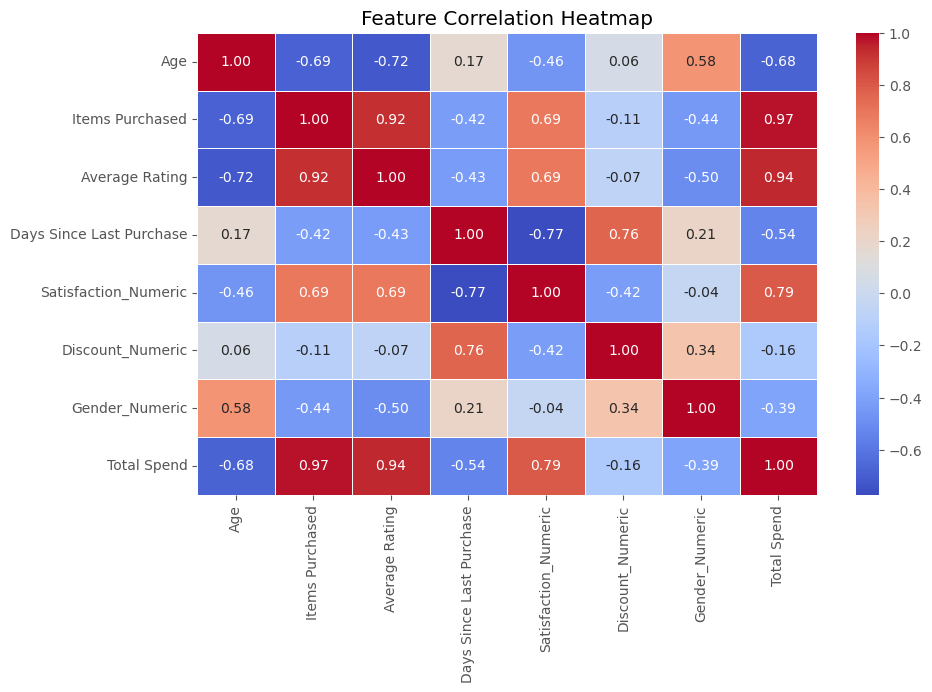

In [4]:
# Visualize correlations to understand relationships
plt.figure(figsize=(10, 6))
\
# Combine X and y temporarily for the heatmap
heatmap_data = pd.concat([X_imputed, y], axis=1)
corr_matrix = heatmap_data.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [5]:
# 1. Linear Regression (Ordinary Least Squares)
lr_model = LinearRegression()
lr_model.fit(X_train_scaled_df, y_train)
y_pred_lr = lr_model.predict(X_test_scaled_df)

# 2. Ridge Regression (L2 Regularization)
# Alpha controls regularization strength. Higher alpha = stronger penalty.
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled_df, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled_df)

# 3. Lasso Regression (L1 Regularization)
# Can drive coefficients to zero, effectively performing feature selection.
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train_scaled_df, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled_df)

print("Linear models trained.")

Linear models trained.


In [6]:
# 4. Decision Tree
# Note: We use unscaled data (X_train, X_test) for the Tree because 
# trees are scale-invariant and it keeps the split rules interpretable (e.g., "Age <= 30").
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

print("Decision Tree trained.")

Decision Tree trained.


In [7]:
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2 Score': r2}

# Compile results
results = [
    evaluate_model("Linear Regression", y_test, y_pred_lr),
    evaluate_model("Ridge Regression", y_test, y_pred_ridge),
    evaluate_model("Lasso Regression", y_test, y_pred_lasso),
    evaluate_model("Decision Tree (Depth 5)", y_test, y_pred_tree)
]

results_df = pd.DataFrame(results).set_index('Model')
print("--- Model Performance Leaderboard ---")
display(results_df.sort_values(by='RMSE'))

--- Model Performance Leaderboard ---


,MAE,RMSE,R2 Score
Model,,,
Decision Tree (Depth 5),6.1029,11.1229,0.9991
Linear Regression,33.0505,43.7092,0.9859
Lasso Regression,33.0954,43.7588,0.9858
Ridge Regression,32.8250,43.9469,0.9857


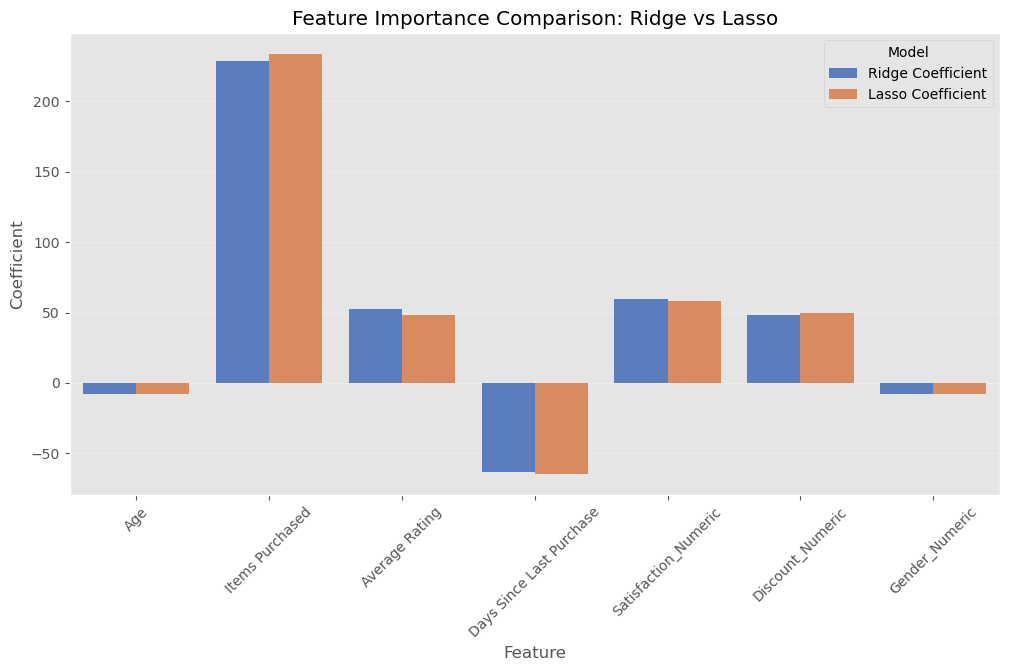

In [10]:
# Create DataFrame for Coefficients
coef_data = {
    'Feature': features_list,
    'Ridge Coefficient': ridge_model.coef_,
    'Lasso Coefficient': lasso_model.coef_
}
coef_df = pd.DataFrame(coef_data)

# Melt for seaborn plotting
coef_melted = coef_df.melt(id_vars='Feature', var_name='Model', value_name='Coefficient')

plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Coefficient', hue='Model', data=coef_melted, palette='muted')
plt.title("Feature Importance Comparison: Ridge vs Lasso")
plt.xticks(rotation=45)
plt.grid(True, axis='y', alpha=0.3)
plt.show()

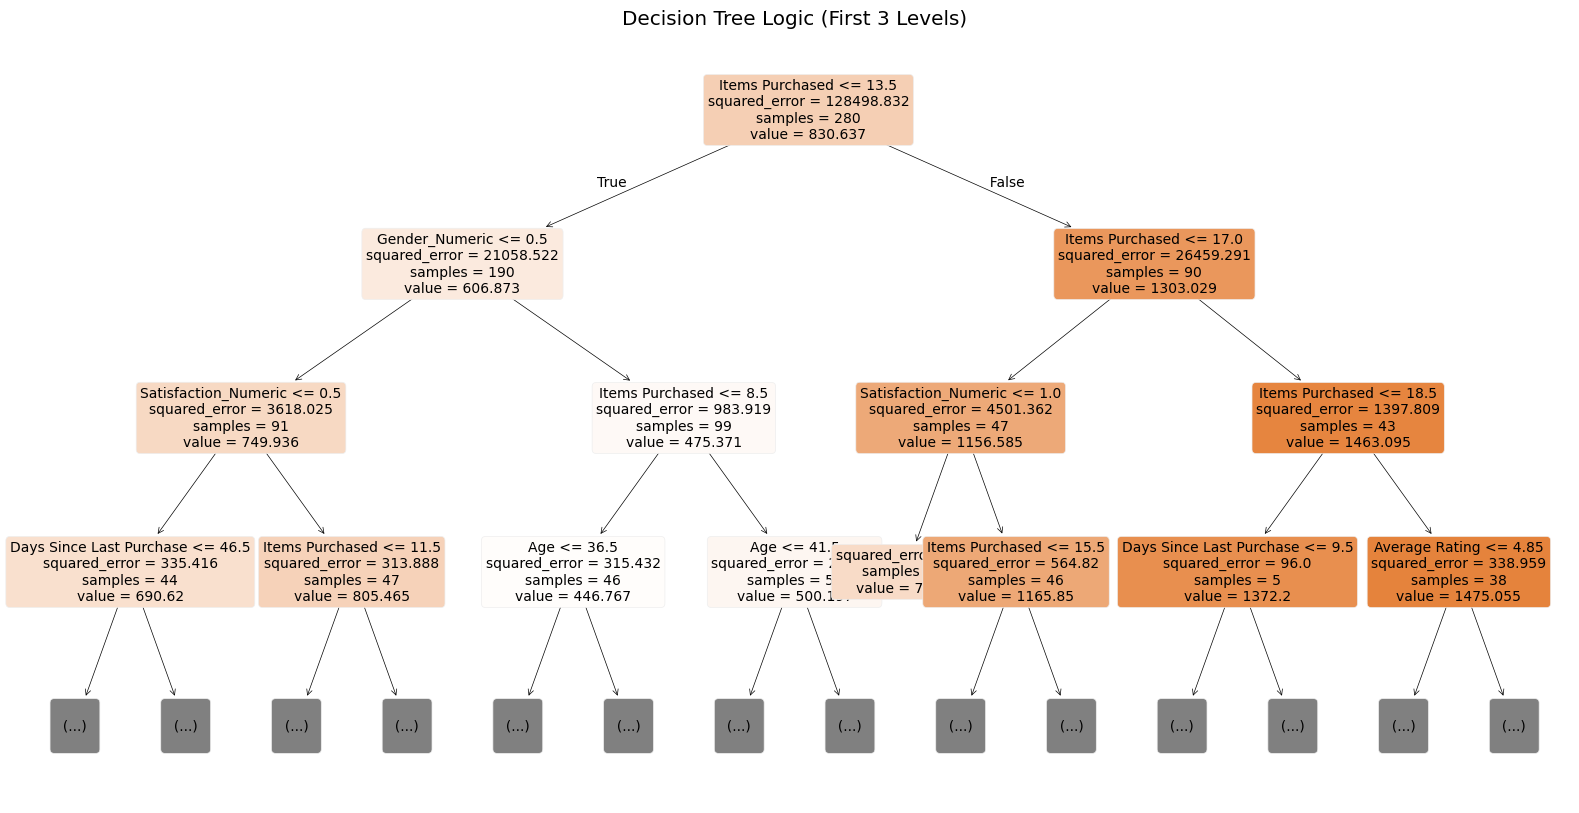

In [9]:
plt.figure(figsize=(20, 10))
plot_tree(tree_model, 
          feature_names=features_list, 
          filled=True, 
          rounded=True, 
          fontsize=10,
          max_depth=3) # Limiting depth for readability
plt.title("Decision Tree Logic (First 3 Levels)")
plt.show()